# Multi-Label U-Net Training (With No Electronic Glitches) on Real ACT Data

## 1. Imports and Configuration

In [16]:
import os
from pathlib import Path
import random
import time
import datetime
import csv
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

from torchmetrics.classification import MultilabelJaccardIndex, MultilabelAccuracy



### 1.1. Configuration

In [ ]:
NUM_CLASSES    = 3                   # CR, PS, EL
BATCH_SIZE     = 8
EPOCHS         = 10 * 12
LR             = 1e-3
DEVICE         = "cuda" if torch.cuda.is_available() else "cpu"
CPU_COUNT      = os.cpu_count()
NUM_WORKERS    = 32

CHECKPOINT_DIR = Path("checkpoints_multilabel_noEL")
CHECKPOINT_DIR.mkdir(exist_ok=True)
LOG_PATH       = Path("run_log_multilabel_noEL.csv")

print(f"Device: {DEVICE}, CUDA Available: {torch.cuda.is_available()}")

Device: cuda, CUDA Available: True


## 2. Sanity Check: Load & Display One Raw Image

Raw image range: min=0.0, max=181.0


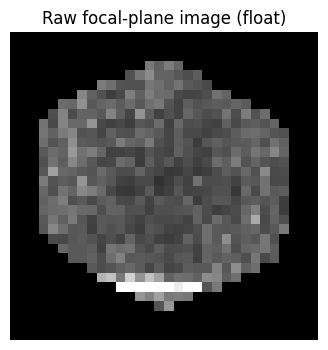

In [18]:
example_img_path = Path("/home/theanas12/anasProjects/cmb_Unet_run1/data/real_converted_images32/images/point_source/TOD_1567419530.1567428401.ar5:f090_converted_10914-11427.png")

# Load and display
import PIL.Image as Image
img = np.array(Image.open(example_img_path).convert('F'), dtype=np.float32)
print(f"Raw image range: min={img.min()}, max={img.max()}")
plt.figure(figsize=(4,4))
plt.imshow(img, cmap='gray')
plt.title('Raw focal-plane image (float)')
plt.axis('off')
plt.show()

## 3. Optional Normalization Transform

Normalized image range: min=0.000, max=1.000


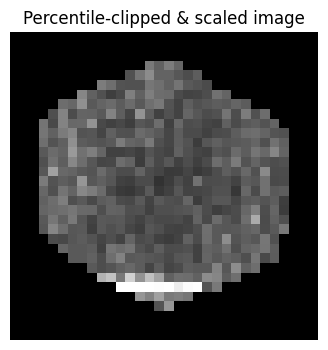

In [19]:
# Re-apply the same normalization as synthetic pipeline if needed.
# Here: percentile clipping to [0.5,99.5] then scale to [0,1].
# %%
def pct_clip_norm(img, lo_pct=0.5, hi_pct=99.5):
    lo, hi = np.percentile(img, [lo_pct, hi_pct])
    img2 = np.clip(img, lo, hi)
    return (img2 - lo) / (hi - lo + 1e-12)

# Sanity check of normalization
normed = pct_clip_norm(img)
print(f"Normalized image range: min={normed.min():.3f}, max={normed.max():.3f}")
plt.figure(figsize=(4,4))
plt.imshow(normed, cmap='gray')
plt.title('Percentile-clipped & scaled image')
plt.axis('off')
plt.show()

## 4. Dataset Definition

In [20]:
class TelescopeDataset(Dataset):
    def __init__(self, img_dir, mask_dir_base, transform=None):
        """
        img_dir           : Path to images/<class> subfolders
        mask_dir_base     : Path to base masks folder containing class subfolders
        transform         : function to normalize image arrays
        """
        self.transform = transform
        self.samples = []
        for cls in ['cosmic_ray', 'point_source', 'none']:
            cls_img_dir = img_dir / cls
            for img_path in cls_img_dir.glob("*.png"):
                self.samples.append((img_path, cls))
        self.mask_dir_base = mask_dir_base

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, cls = self.samples[idx]
        # Load and normalize image
        img_arr = np.array(Image.open(img_path).convert('F'), dtype=np.float32)
        if self.transform:
            img_arr = self.transform(img_arr)
        img_tensor = torch.tensor(img_arr, dtype=torch.float32).unsqueeze(0)  # (1,H,W)
        # Load three masks by stacking binary arrays (missing masks become all-zero)
        mask_list = []
        for mcls in ['cosmic_ray', 'point_source', 'none']:
            mask_path = self.mask_dir_base / mcls / img_path.name
            if mask_path.exists():
                m_arr = np.array(Image.open(mask_path).convert('L'), dtype=np.uint8)
                mask = (m_arr > 0).astype(np.uint8)
            else:
                mask = np.zeros_like(img_arr, dtype=np.uint8)
            mask_list.append(mask)
        mask_tensor = torch.tensor(np.stack(mask_list, 0), dtype=torch.float32)  # (3,H,W)
        return img_tensor, mask_tensor

## 5. Prepare DataLoaders

In [21]:
base = Path("/home/theanas12/anasProjects/cmb_Unet_run1/data/real_converted_images32")
# mask_dir_base points to the 'masks' folder containing class subfolders
dataset = TelescopeDataset(
    img_dir=base / 'images',
    mask_dir_base=base / 'masks',
    transform=pct_clip_norm
)

# Split into train/val/test
tot = len(dataset)
train_end = int(tot * 0.7)
val_end   = int(tot * 0.85)
indices = list(range(tot))
random.shuffle(indices)
train_idx, val_idx, test_idx = indices[:train_end], indices[train_end:val_end], indices[val_end:]

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds   = torch.utils.data.Subset(dataset, val_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

print(f"Dataset sizes → train: {len(train_ds)}, val: {len(val_ds)}, test: {len(test_ds)}")

# Sanity check a batch
i_imgs, i_msks = next(iter(train_loader))
print(i_imgs.shape, i_msks.shape)  # expect (B,1,H,W), (B,3,H,W)
i_imgs, i_msks = next(iter(train_loader))
print(i_imgs.shape, i_msks.shape)  # expect (B,1,H,W), (B,3,H,W)


Dataset sizes → train: 1848, val: 396, test: 397


torch.Size([8, 1, 32, 32]) torch.Size([8, 3, 32, 32])
torch.Size([8, 1, 32, 32]) torch.Size([8, 3, 32, 32])


## 6. Model, Losses, Metrics, Optimizer

In [22]:
class ConvBNReLU(nn.Sequential):
    def __init__(self, in_c, out_c):
        super().__init__(
            nn.Conv2d(in_c, out_c, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.ReLU(inplace=True)
        )

class TinyUNet(nn.Module):
    def __init__(self, n_classes=NUM_CLASSES, base_c=32,
                 p_drop=0.25, pre_norm=None):
        """
        pre_norm : nn.Module that normalises the input, e.g. ZNorm.
                   If None → nn.Identity().
        """
        super().__init__()
        self.pre_norm = pre_norm if pre_norm is not None else nn.Identity()

        # ────────────── Encoder ──────────────
        self.enc1 = nn.Sequential(ConvBNReLU(1,  base_c),
                                  ConvBNReLU(base_c, base_c))
        self.enc2 = nn.Sequential(nn.MaxPool2d(2),
                                  ConvBNReLU(base_c, base_c*2))
        # Bottleneck
        self.bott = nn.Sequential(nn.MaxPool2d(2),
                                  ConvBNReLU(base_c*2, base_c*4))
        # Decoder
        self.up1  = nn.ConvTranspose2d(base_c*4, base_c*2, 2, stride=2)
        self.dec1 = nn.Sequential(ConvBNReLU(base_c*4, base_c*2),
                                  nn.Dropout2d(p=p_drop))
        self.up2  = nn.ConvTranspose2d(base_c*2, base_c, 2, stride=2)
        self.dec2 = nn.Sequential(ConvBNReLU(base_c*2, base_c),
                                  nn.Dropout2d(p=p_drop))
        # Output
        self.outc = nn.Conv2d(base_c, n_classes, 1)

    def forward(self, x):
        x  = self.pre_norm(x)
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        b  = self.bott(e2)
        d1 = self.up1(b)
        d1 = self.dec1(torch.cat([d1, e2], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e1], dim=1))
        return self.outc(d2)          # logits



class DiceLoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__(); self.eps = eps
    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        num = 2 * (preds * targets).sum(dim=(2,3))
        den = preds.sum(dim=(2,3)) + targets.sum(dim=(2,3)) + self.eps
        dice = 1 - (num / den)
        return dice.mean()
    

model = TinyUNet(n_classes=NUM_CLASSES).to(DEVICE)


bce_loss = nn.BCEWithLogitsLoss()
dice_loss = DiceLoss()

# Metrics
metric_iou = MultilabelJaccardIndex(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(DEVICE)
metric_acc = MultilabelAccuracy(num_labels=NUM_CLASSES, threshold=0.5, average=None).to(DEVICE)

# Optimizer & scheduler
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=3, factor=0.3)


## 7. Training & Validation Loops

### 7.1.Epoch Function

In [23]:
def run_epoch(loader, train=True, epoch_idx=0):
    model.train(train)
    total_loss, n_batches = 0.0, 0
    metric_iou.reset(); metric_acc.reset()

    loop = tqdm(loader, desc=("train" if train else "val") + f" {epoch_idx:03d}", leave=False)
    for batch_idx, (imgs, msks) in enumerate(loop):
        imgs, msks = imgs.to(DEVICE), msks.to(DEVICE)
        # Sanity check on first batch of first epoch
        if batch_idx == 0 and epoch_idx == 1:
            print(f"[Sanity] imgs.shape={imgs.shape}, msks.shape={msks.shape}")
        logits = model(imgs)
        if batch_idx == 0 and epoch_idx == 1:
            print(f"[Sanity] logits.shape={logits.shape}, msks.shape={msks.shape}")
        # Compute loss
        loss = 0.5 * bce_loss(logits, msks) + 0.5 * dice_loss(logits, msks)
        if train:
            opt.zero_grad()
            loss.backward()
            opt.step()
        total_loss += loss.item()
        n_batches += 1

        # Update metrics and progress bar
        metric_iou.update(torch.sigmoid(logits), msks.int())
        metric_acc.update(torch.sigmoid(logits), msks.int())
        loop.set_postfix(loss=loss.item())

    avg_loss = total_loss / n_batches
    iou = metric_iou.compute()
    acc = metric_acc.compute()
    mean_iou = iou.mean().item()
    return avg_loss, mean_iou, acc.mean().item(), iou, acc

### 7.2. Saving Checkpoints and Logging Logic

In [ ]:
def save_ckpt(model, optimizer, epoch, tag):
    fname = CHECKPOINT_DIR / f"unet_multilabel_noEL_ep{epoch}_{tag}.pt"
    torch.save({
        "epoch":      epoch,
        "model":      model.state_dict(),
        "optimizer":  optimizer.state_dict()
    }, fname)
    print(f"✅  saved → {fname}")


def next_run_id():
    """Auto-increment run ID by counting existing lines in run_log.csv."""
    if LOG_PATH.exists():
        with LOG_PATH.open() as f:
            return sum(1 for _ in f)            # header + previous rows
    return 1                                    # first ever run

def log_run(**fields):
    """Append one line to LOG_PATH (create with header if missing)."""
    header_needed = not LOG_PATH.exists()
    with LOG_PATH.open("a", newline="") as f:
        writer = csv.DictWriter(f, fieldnames=fields.keys())
        if header_needed:
            writer.writeheader()
        writer.writerow(fields)


### 7.3. Training Loop

In [ ]:
train_hist, val_hist = [], []
iou_train_hist, iou_val_hist = [], []
acc_train_hist, acc_val_hist = [], []
start_time = time.time()
best_iou = 0.0
best_val_loss = float('inf')
stall = 0
PATIENCE = 8
MIN_DELTA = 1e-5

for epoch in trange(1, EPOCHS + 1, desc='Epochs'):
    tr_loss, tr_iou, tr_acc, tr_iou_vec, tr_acc_vec = run_epoch(train_loader, True, epoch)
    val_loss, val_iou, val_acc, val_iou_vec, val_acc_vec = run_epoch(val_loader, False, epoch)
    sched.step(val_loss)

    print(
        f"Epoch {epoch:03d} | train_loss={tr_loss:.4f} val_loss={val_loss:.4f} | "
        f"IoU_CR={val_iou_vec[0]:.3f} IoU_PS={val_iou_vec[1]:.3f} IoU_EL={val_iou_vec[2]:.3f}"
    )

    train_hist.append(tr_loss)
    val_hist.append(val_loss)
    iou_train_hist.append(tr_iou)
    iou_val_hist.append(val_iou_vec)
    acc_train_hist.append(tr_acc)
    acc_val_hist.append(val_acc)

    # Save checkpoints
    save_ckpt(model, opt, epoch, tag='last')
    if val_iou > best_iou:
        best_iou = val_iou
        save_ckpt(model, opt, epoch, tag='best')

    # Early stopping
    if val_loss < best_val_loss - MIN_DELTA:
        best_val_loss = val_loss
        stall = 0
    else:
        stall += 1
        print(f"  no val-loss improvement for {stall}/{PATIENCE} epochs")
        if stall >= PATIENCE:
            print(f"Early stopping at epoch {epoch}")
            break

elapsed = time.time() - start_time
print(f"Training complete — best val IoU = {best_iou:.3f} in {int(elapsed)}s")
print(f"Final Validation IoU - CR: {val_iou_vec[0]:.3f}, PS: {val_iou_vec[1]:.3f}, EL: {val_iou_vec[2]:.3f}")


Epochs:   0%|          | 0/120 [00:00<?, ?it/s]

[Sanity] imgs.shape=torch.Size([8, 1, 32, 32]), msks.shape=torch.Size([8, 3, 32, 32])
[Sanity] logits.shape=torch.Size([8, 3, 32, 32]), msks.shape=torch.Size([8, 3, 32, 32])



val 001:  22%|██▏       | 11/50 [00:01<00:03, 12.12it/s, loss=0.443]

[Sanity] imgs.shape=torch.Size([8, 1, 32, 32]), msks.shape=torch.Size([8, 3, 32, 32])
[Sanity] logits.shape=torch.Size([8, 3, 32, 32]), msks.shape=torch.Size([8, 3, 32, 32])


Epochs:   1%|          | 1/120 [00:05<10:31,  5.31s/it]

Epoch 001 | train_loss=0.5949 val_loss=0.4568 | IoU_CR=0.409 IoU_PS=0.630 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep1_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep1_best.pt


Epochs:   2%|▏         | 2/120 [00:10<10:46,  5.48s/it]

Epoch 002 | train_loss=0.4211 val_loss=0.3988 | IoU_CR=0.537 IoU_PS=0.714 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep2_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep2_best.pt


Epochs:   2%|▎         | 3/120 [00:15<10:17,  5.28s/it]

Epoch 003 | train_loss=0.3979 val_loss=0.3895 | IoU_CR=0.616 IoU_PS=0.707 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep3_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep3_best.pt


Epochs:   3%|▎         | 4/120 [00:20<09:55,  5.14s/it]

Epoch 004 | train_loss=0.3927 val_loss=0.3874 | IoU_CR=0.599 IoU_PS=0.747 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep4_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep4_best.pt


Epochs:   4%|▍         | 5/120 [00:25<09:37,  5.02s/it]

Epoch 005 | train_loss=0.3896 val_loss=0.3866 | IoU_CR=0.608 IoU_PS=0.769 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep5_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep5_best.pt


Epochs:   5%|▌         | 6/120 [00:30<09:40,  5.09s/it]

Epoch 006 | train_loss=0.3878 val_loss=0.3855 | IoU_CR=0.610 IoU_PS=0.770 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep6_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep6_best.pt


Epochs:   6%|▌         | 7/120 [00:35<09:31,  5.06s/it]

Epoch 007 | train_loss=0.3861 val_loss=0.3866 | IoU_CR=0.610 IoU_PS=0.725 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep7_last.pt
  no val-loss improvement for 1/8 epochs


Epochs:   7%|▋         | 8/120 [00:41<09:39,  5.17s/it]

Epoch 008 | train_loss=0.3853 val_loss=0.3864 | IoU_CR=0.624 IoU_PS=0.772 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep8_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep8_best.pt
  no val-loss improvement for 2/8 epochs


Epochs:   8%|▊         | 9/120 [00:46<09:33,  5.16s/it]

Epoch 009 | train_loss=0.3844 val_loss=0.3834 | IoU_CR=0.627 IoU_PS=0.795 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep9_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep9_best.pt


Epochs:   8%|▊         | 10/120 [00:51<09:19,  5.08s/it]

Epoch 010 | train_loss=0.3845 val_loss=0.3853 | IoU_CR=0.629 IoU_PS=0.776 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep10_last.pt
  no val-loss improvement for 1/8 epochs


Epochs:   9%|▉         | 11/120 [00:56<09:29,  5.22s/it]

Epoch 011 | train_loss=0.3836 val_loss=0.3833 | IoU_CR=0.631 IoU_PS=0.800 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep11_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep11_best.pt


Epochs:  10%|█         | 12/120 [01:01<09:14,  5.14s/it]

Epoch 012 | train_loss=0.3832 val_loss=0.3864 | IoU_CR=0.627 IoU_PS=0.764 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep12_last.pt
  no val-loss improvement for 1/8 epochs


Epochs:  11%|█         | 13/120 [01:07<09:12,  5.16s/it]

Epoch 013 | train_loss=0.3823 val_loss=0.3836 | IoU_CR=0.641 IoU_PS=0.787 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep13_last.pt
  no val-loss improvement for 2/8 epochs


Epochs:  12%|█▏        | 14/120 [01:12<09:11,  5.21s/it]

Epoch 014 | train_loss=0.3813 val_loss=0.3834 | IoU_CR=0.614 IoU_PS=0.797 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep14_last.pt
  no val-loss improvement for 3/8 epochs


Epochs:  12%|█▎        | 15/120 [01:17<09:12,  5.26s/it]

Epoch 015 | train_loss=0.3809 val_loss=0.3828 | IoU_CR=0.632 IoU_PS=0.801 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep15_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep15_best.pt


Epochs:  13%|█▎        | 16/120 [01:23<09:06,  5.26s/it]

Epoch 016 | train_loss=0.3815 val_loss=0.3823 | IoU_CR=0.644 IoU_PS=0.779 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep16_last.pt


Epochs:  14%|█▍        | 17/120 [01:28<09:02,  5.27s/it]

Epoch 017 | train_loss=0.3805 val_loss=0.3831 | IoU_CR=0.620 IoU_PS=0.807 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep17_last.pt
  no val-loss improvement for 1/8 epochs


Epochs:  15%|█▌        | 18/120 [01:33<09:09,  5.39s/it]

Epoch 018 | train_loss=0.3801 val_loss=0.3825 | IoU_CR=0.645 IoU_PS=0.811 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep18_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep18_best.pt
  no val-loss improvement for 2/8 epochs


Epochs:  16%|█▌        | 19/120 [01:39<09:12,  5.47s/it]

Epoch 019 | train_loss=0.3798 val_loss=0.3824 | IoU_CR=0.648 IoU_PS=0.782 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep19_last.pt
  no val-loss improvement for 3/8 epochs


Epochs:  17%|█▋        | 20/120 [01:45<09:06,  5.46s/it]

Epoch 020 | train_loss=0.3798 val_loss=0.3837 | IoU_CR=0.628 IoU_PS=0.807 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep20_last.pt
  no val-loss improvement for 4/8 epochs


Epochs:  18%|█▊        | 21/120 [01:50<09:00,  5.46s/it]

Epoch 021 | train_loss=0.3756 val_loss=0.3799 | IoU_CR=0.658 IoU_PS=0.814 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep21_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep21_best.pt


Epochs:  18%|█▊        | 22/120 [01:56<08:59,  5.51s/it]

Epoch 022 | train_loss=0.3745 val_loss=0.3799 | IoU_CR=0.655 IoU_PS=0.826 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep22_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep22_best.pt
  no val-loss improvement for 1/8 epochs


Epochs:  19%|█▉        | 23/120 [02:01<08:49,  5.45s/it]

Epoch 023 | train_loss=0.3737 val_loss=0.3805 | IoU_CR=0.654 IoU_PS=0.825 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep23_last.pt
  no val-loss improvement for 2/8 epochs


Epochs:  20%|██        | 24/120 [02:06<08:43,  5.45s/it]

Epoch 024 | train_loss=0.3732 val_loss=0.3802 | IoU_CR=0.657 IoU_PS=0.828 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep24_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep24_best.pt
  no val-loss improvement for 3/8 epochs


Epochs:  21%|██        | 25/120 [02:12<08:34,  5.41s/it]

Epoch 025 | train_loss=0.3727 val_loss=0.3804 | IoU_CR=0.652 IoU_PS=0.820 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep25_last.pt
  no val-loss improvement for 4/8 epochs


Epochs:  22%|██▏       | 26/120 [02:17<08:28,  5.41s/it]

Epoch 026 | train_loss=0.3704 val_loss=0.3795 | IoU_CR=0.662 IoU_PS=0.832 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep26_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep26_best.pt


Epochs:  22%|██▎       | 27/120 [02:23<08:25,  5.44s/it]

Epoch 027 | train_loss=0.3700 val_loss=0.3793 | IoU_CR=0.661 IoU_PS=0.830 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep27_last.pt


Epochs:  23%|██▎       | 28/120 [02:28<08:29,  5.53s/it]

Epoch 028 | train_loss=0.3699 val_loss=0.3799 | IoU_CR=0.663 IoU_PS=0.830 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep28_last.pt
  no val-loss improvement for 1/8 epochs


Epochs:  24%|██▍       | 29/120 [02:34<08:26,  5.56s/it]

Epoch 029 | train_loss=0.3694 val_loss=0.3793 | IoU_CR=0.662 IoU_PS=0.832 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep29_last.pt
  no val-loss improvement for 2/8 epochs


Epochs:  25%|██▌       | 30/120 [02:39<08:17,  5.52s/it]

Epoch 030 | train_loss=0.3688 val_loss=0.3801 | IoU_CR=0.658 IoU_PS=0.828 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep30_last.pt
  no val-loss improvement for 3/8 epochs


Epochs:  26%|██▌       | 31/120 [02:45<08:09,  5.50s/it]

Epoch 031 | train_loss=0.3685 val_loss=0.3802 | IoU_CR=0.660 IoU_PS=0.828 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep31_last.pt
  no val-loss improvement for 4/8 epochs


Epochs:  27%|██▋       | 32/120 [02:50<08:04,  5.51s/it]

Epoch 032 | train_loss=0.3674 val_loss=0.3801 | IoU_CR=0.658 IoU_PS=0.831 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep32_last.pt
  no val-loss improvement for 5/8 epochs


Epochs:  28%|██▊       | 33/120 [02:56<07:58,  5.50s/it]

Epoch 033 | train_loss=0.3675 val_loss=0.3800 | IoU_CR=0.661 IoU_PS=0.833 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep33_last.pt
  no val-loss improvement for 6/8 epochs


Epochs:  28%|██▊       | 34/120 [03:02<07:56,  5.54s/it]

Epoch 034 | train_loss=0.3668 val_loss=0.3801 | IoU_CR=0.661 IoU_PS=0.834 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep34_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep34_best.pt
  no val-loss improvement for 7/8 epochs


Epochs:  28%|██▊       | 34/120 [03:07<07:54,  5.52s/it]

Epoch 035 | train_loss=0.3670 val_loss=0.3798 | IoU_CR=0.663 IoU_PS=0.834 IoU_EL=0.000
✅  saved → checkpoints_multilabel/unet_multilabel_ep35_last.pt
✅  saved → checkpoints_multilabel/unet_multilabel_ep35_best.pt
  no val-loss improvement for 8/8 epochs
Early stopping at epoch 35
Training complete — best val IoU = 0.499 in 187s
Final Validation IoU - CR: 0.663, PS: 0.834


### 7.4. Log Run Information 

In [26]:
# ----- prepare one row of metrics & settings ------------------------------
run_id = next_run_id()

log_run(
    run_id         = run_id,
    timestamp      = datetime.datetime.now().isoformat(timespec="seconds"),
    epochs         = epoch,                    # last epoch actually run
    batch_size     = BATCH_SIZE,
    num_workers    = NUM_WORKERS,
    dataset_size   = len(train_ds) + len(val_ds) + len(test_ds),
    train_loss     = train_hist[-1],
    val_loss       = val_hist[-1],
    best_val_iou   = best_iou,
    iou_cosmic     = val_iou_vec[0].cpu().item(),    # last epoch's per-class IoU
    iou_pointsrc   = val_iou_vec[1].cpu().item(),
    pixel_acc      = acc_val_hist[-1],
    gpu_used       = torch.cuda.current_device(),
    train_time_hms = str(datetime.timedelta(seconds=int(elapsed)))
)

print(f"📝  logged run #{run_id} to {LOG_PATH}")

📝  logged run #2 to run_log_multilabel.csv


## 8. Plot Training Curves

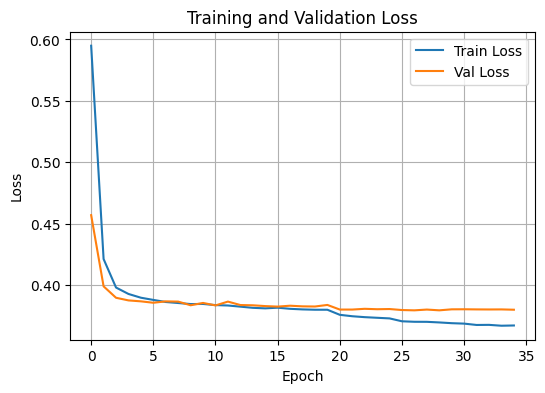

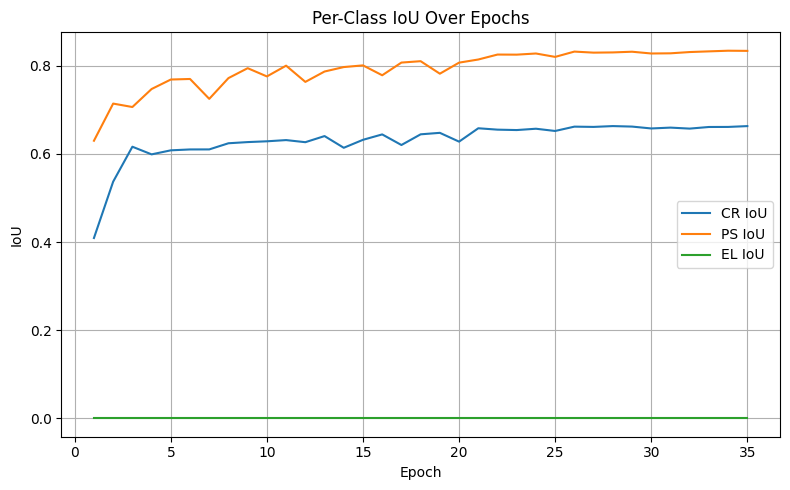

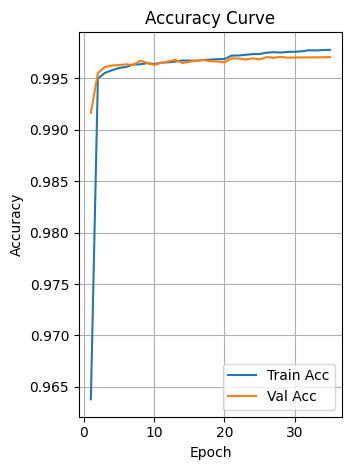

In [27]:
# Loss curves
plt.figure(figsize=(6,4))
plt.plot(train_hist, label='Train Loss')
plt.plot(val_hist,   label='Val Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend(); plt.grid(True)
plt.show()

# IoU and Accuracy curves
# Convert tensors to CPU floats
cr_iou = [t[0].cpu().item() for t in iou_val_hist]
ps_iou = [t[1].cpu().item() for t in iou_val_hist]
el_iou = [t[2].cpu().item() for t in iou_val_hist]

epochs = range(1, len(iou_val_hist) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, cr_iou, label='CR IoU')
plt.plot(epochs, ps_iou, label='PS IoU')
plt.plot(epochs, el_iou, label='EL IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.title('Per-Class IoU Over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.subplot(1,2,2)
plt.plot(epochs, acc_train_hist, label='Train Acc')
plt.plot(epochs, acc_val_hist,   label='Val Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy Curve'); plt.legend(); plt.grid(True)
plt.tight_layout(); plt.show()



## 9. Visualization of Predictions 

✅  checkpoint loaded: unet_multilabel_ep35_best.pt | epoch 35


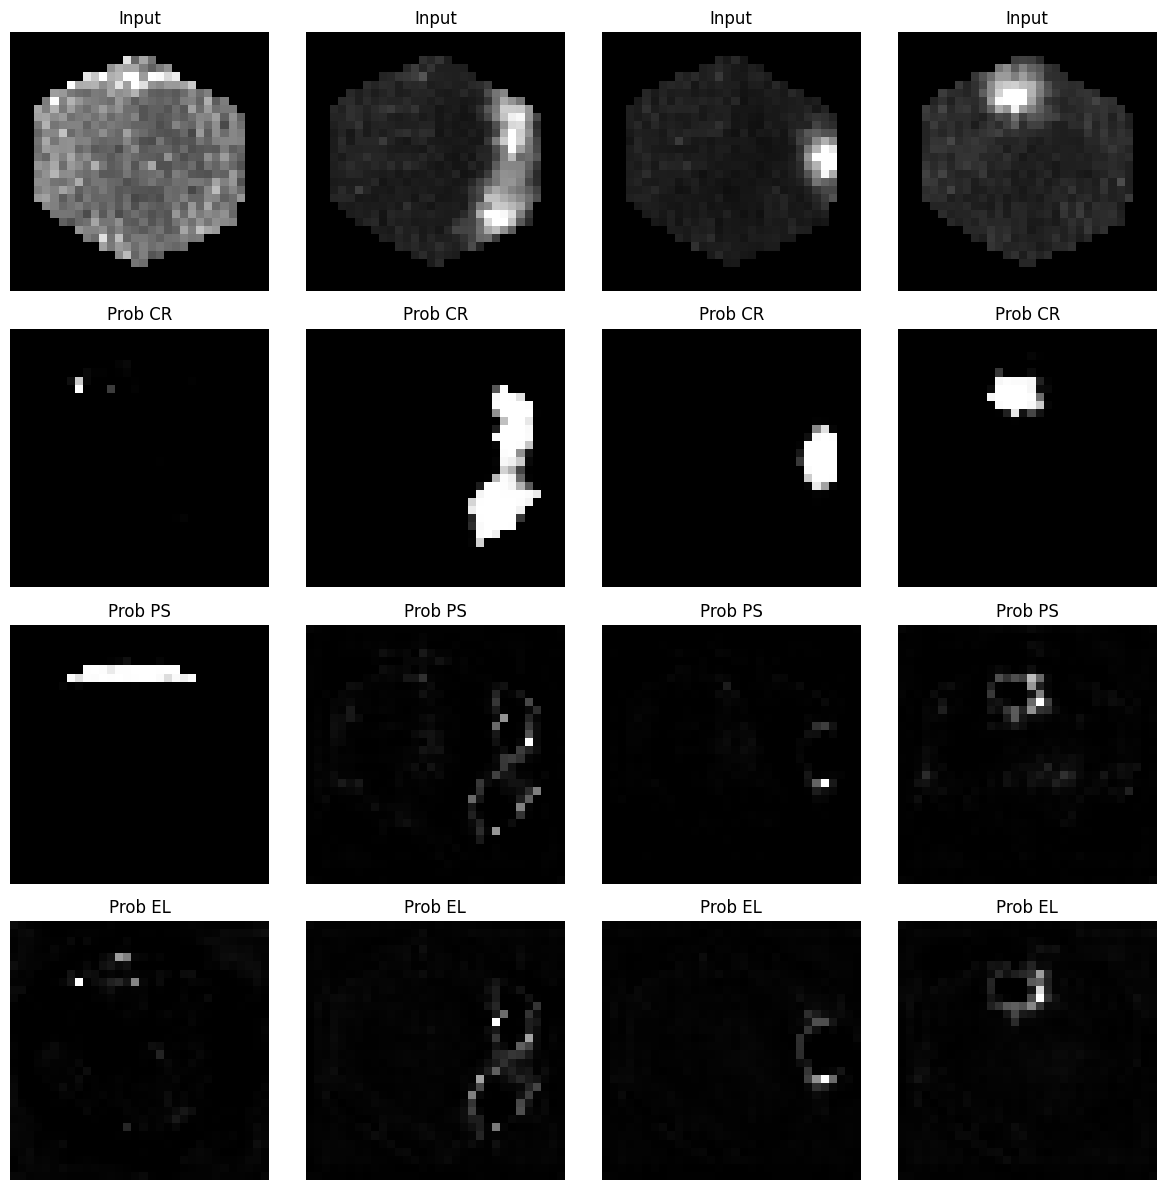

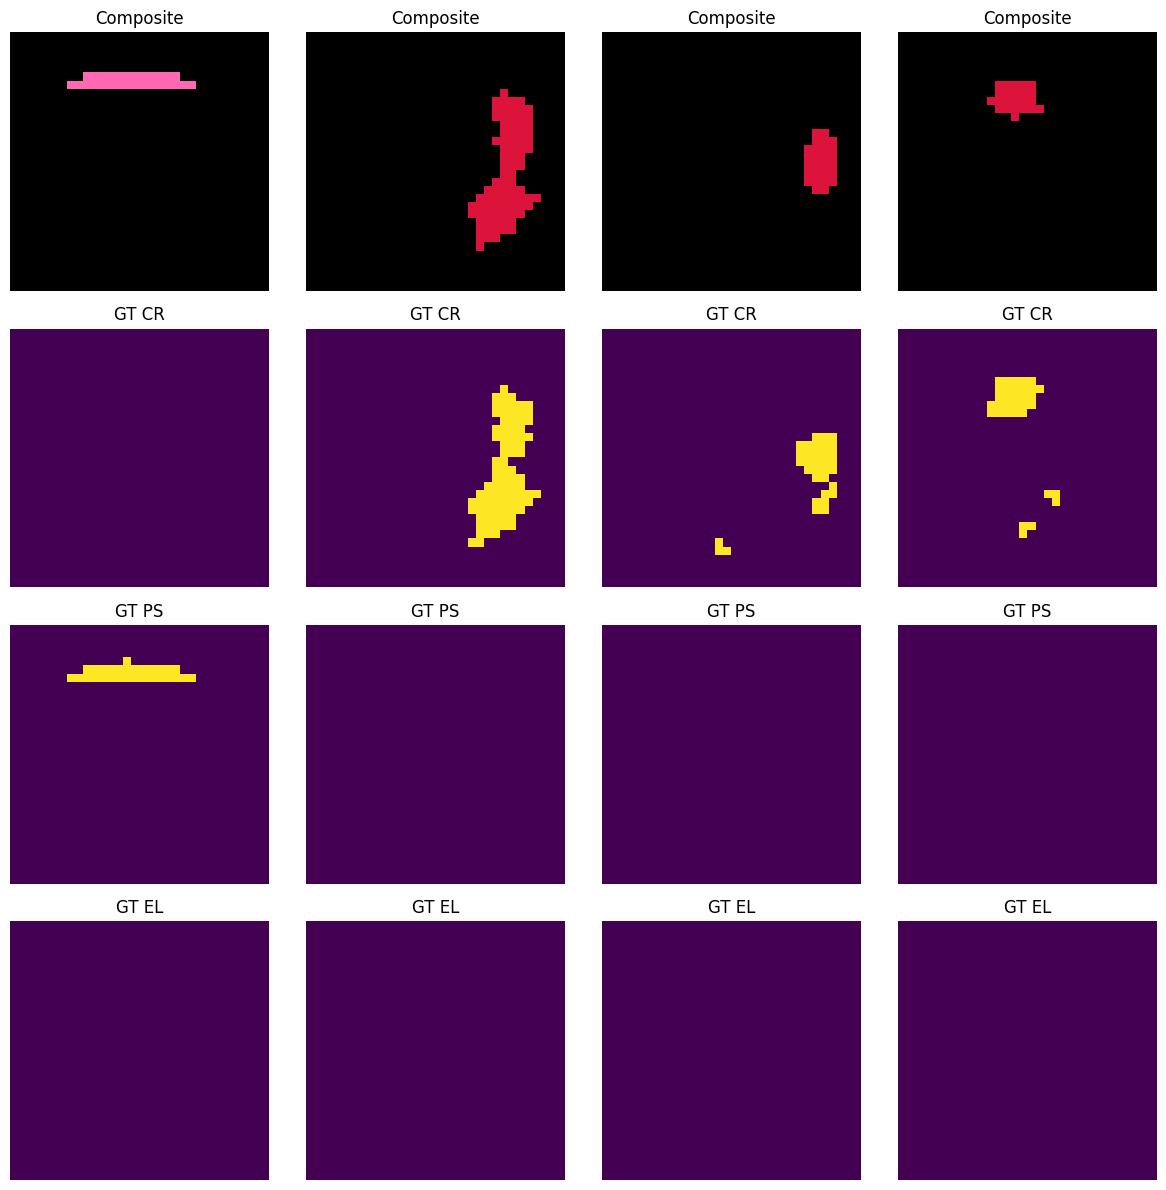

In [28]:
def composite_map(probs, thr=0.5):
    # probs: (3,H,W) tensor
    masks = probs > thr
    colors = torch.tensor([[220,20,60],[255,105,180],[255,255,0]],dtype=torch.uint8)
    H,W = masks.shape[1:]
    comp = torch.zeros(3,H,W,dtype=torch.uint8)
    for i in range(3): comp[:,masks[i]] = colors[i].view(3,1)
    return comp.permute(1,2,0).cpu().numpy()

CKPT_PATH = Path("/home/theanas12/anasProjects/models/checkpoints_multilabel/unet_multilabel_ep26_best.pt")  
CKPT_PATH = Path("/home/theanas12/anasProjects/cmb_Unet_run1/models/checkpoints_multilabel/unet_multilabel_ep35_best.pt")  


DEVICE    = "cuda" if torch.cuda.is_available() else "cpu"         
model = TinyUNet().to(DEVICE)

#2. load weights
ckpt  = torch.load(CKPT_PATH, map_location=DEVICE)
model.load_state_dict(ckpt["model"])   # key name set by save_ckpt
model.eval()                                 # switch to inference mode

print("✅  checkpoint loaded:",
      CKPT_PATH.name, "| epoch", ckpt["epoch"])

# Show one batch
model.eval()
# imgs, msks = next(iter(test_loader))
import random

def shuffle_iter(it):
    entries = list(it)       # collect all batches
    random.shuffle(entries)  # shuffle in place
    return iter(entries)     # return a new iterator

imgs, msks = next(shuffle_iter(iter(test_loader)))
imgs, msks = next(shuffle_iter(iter(val_loader)))
with torch.no_grad():
    preds = torch.sigmoid(model(imgs.to(DEVICE)))

fig, axes = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    axes[0,i].imshow(imgs[i,0],cmap='gray'); axes[0,i].set_title('Input')
    for j,cls in enumerate(['CR','PS','EL']):
        axes[j+1,i].imshow(preds[i,j].cpu(),cmap='gray'); axes[j+1,i].set_title(f'Prob {cls}')
for ax in axes.flatten(): ax.axis('off')
plt.tight_layout(); plt.show()

fig, axes = plt.subplots(4,4,figsize=(12,12))
for i in range(4):
    comp = composite_map(preds[i])
    axes[0,i].imshow(comp); axes[0,i].set_title('Composite')
    axes[1,i].imshow(msks[i,0], cmap='viridis'); axes[1,i].set_title('GT CR')
    axes[2,i].imshow(msks[i,1], cmap='viridis'); axes[2,i].set_title('GT PS')
    axes[3,i].imshow(msks[i,2], cmap='viridis'); axes[3,i].set_title('GT EL')
for ax in axes.flatten(): ax.axis('off')
plt.tight_layout(); plt.show()

## 10. Visualization of Predictions Against Ground Truth

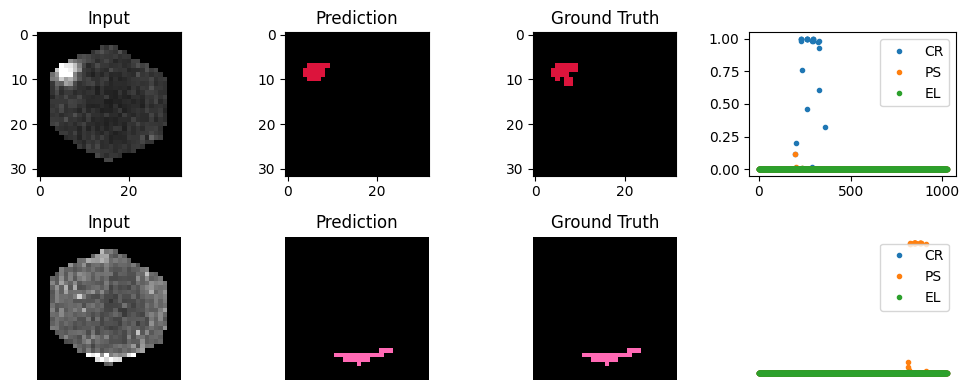

In [29]:
N = 2
model.eval()
fig, axes = plt.subplots(N, 4, figsize=(10, 2*N))
for r in range(N):
    idx = random.randrange(len(test_ds))
    img, msk = test_ds[idx]
    with torch.no_grad():
        pred = torch.sigmoid(model(img.unsqueeze(0).to(DEVICE)))[0]
    # Input
    axes[r,0].imshow(img[0], cmap='gray'); axes[r,0].set_title('Input')
    # Predictions composite
    comp = composite_map(pred, thr=0.75)
    axes[r,1].imshow(comp); axes[r,1].set_title('Prediction')
    # Ground Truth composite
    gt_comp = composite_map(msk)
    axes[r,2].imshow(gt_comp); axes[r,2].set_title('Ground Truth')
    # Per-channel probabilities
    axes[r,3].plot(pred[0].cpu().flatten(), '.', label='CR')
    axes[r,3].plot(pred[1].cpu().flatten(), '.', label='PS')
    axes[r,3].plot(pred[2].cpu().flatten(), '.', label='EL')
    axes[r,3].legend(loc='upper right')
for c in range(4): axes[r,c].axis('off')
plt.tight_layout(); plt.show()